### Main steps
For several song samples:

- load a song stft from data/stft/fft-window-size_fft-hop-length/Album-name/song-name-dir/startoffset-endoffset.stft
- Use the method in [Hermes's paper](https://drive.google.com/file/d/1yYo9DB9Vh0tHoE63swfu78u2_p_fcAD5/view?usp=sharing) (see Fig. 1) to detect the one, two, or three pitches (fundamental frequencies) of the voices in the audio

In [2]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import os
import scipy.signal
import scipy.fft
import scipy
import librosa.display
import math


data_dir = '/Akamai/voice/data/'
tck = None

def get_audio (file):
    global data_dir
    y, sr = librosa.load(data_dir + file)
    return [y, sr]

def smooth(x,window_len=11,window='hanning'):
    if window_len<3:
        return x
    s=np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')
    y=np.convolve(w/w.sum(),s,mode='valid')
    
    return y[(window_len//2):-(window_len//2)]  
    
def init_cubic_spline_interpolation (x_points, y_points):
    # cubic spline interpolation
    # chose 168 different values since 48 reccommended for every octave
    
    global tck
    tck = scipy.interpolate.interp1d(x_points, y_points, kind="cubic")
    
    
def calculate_P (x):
    # if the x value is above the interpolation range, 0 is returned. 
    try:
        return tck(x) * np.arctan(x)
    except:
        return 0

def calculate_h_n (n):
    return 0.84**(n-1)

def calculate_H (s):
    ans = 0
    N = 15
    for i in range(1, N+1):
        ans += calculate_h_n(i) * calculate_P(s * i) #calculate_P(s + s * math.log2(i))    
    return ans

def estimate_pitch (vals):
    pitch = 0
    summ = vals[0]
    
    for i in range(1, len(vals)):
        if (vals[i] > summ):
            pitch = i
            summ = vals[i]
    return pitch


In [17]:
# gets audio applies hamming and pads with zeros and finds FFT
audio, sr = get_audio("Basiani/01 Mravalzhamier/65-67.wav") #"Basiani/01 Mravalzhamier/65-67.wav", "Pure Tones/440.wav"
hamming_window = scipy.signal.hamming(audio.shape[0])
pad = 156000
T = 2.0
prod = np.multiply(audio, hamming_window)
prod = np.pad(prod, (0, pad), 'constant')
x = np.linspace(0, sr, np.int(T * sr + pad))
ham_fft = np.abs(scipy.fft.fft(prod))

ham_fft = ham_fft[:ham_fft.shape[0]//2]
x = x[:x.shape[0]//2]
                

# find derivative and then calculate relative maximums
# not ideal in my opinion probably needs to be changed.
# this needs to be fixed, doesn't remove anything right now
dx = x[1] - x[0]
second_order = np.diff(ham_fft)/dx

relative_maxes = [] 
for i in range(len(second_order)-1):
    if (second_order[i] > 0 and second_order[i+1] < 0):
        relative_maxes.append(x[i])
        

# set values that are 19.53 Hz away from relative max to zero
for i in range(len(relative_maxes)-1):
    j = 20 + relative_maxes[i]
    while (j < relative_maxes[i+1] - 20):
        ham_fft[j] = 0
        j += 1

#apply hanning filter
# hanning_window = np.hanning(ham_fft.shape[0])
# han_fft = np.multiply(ham_fft, hanning_window)
han_fft = smooth(ham_fft, window_len=15)

# find cubic_spline_interpolation
init_cubic_spline_interpolation(x, han_fft)

### Graphs

1. The first graph is the actual audio
2. The second graph is when audio is multiplied by hamming window, padded with 156 zeros and then applied FFT.
3. The third graph is when the frequencies which are too far from relative maximums are removed and hanning is applied to smooth the curve.
4. This is the cubic spline interpolated function multiplied with arctan. 

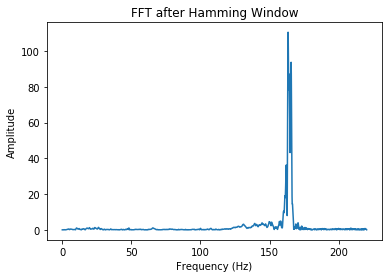

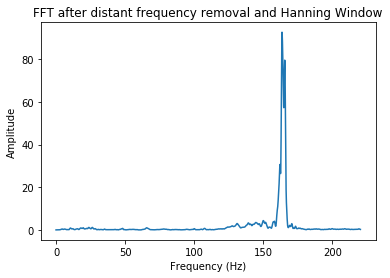

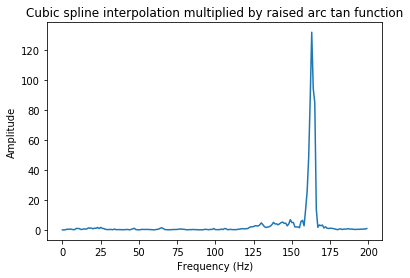

In [9]:
plt.figure()
plt.title("FFT after Hamming Window")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.plot(x[:2000], ham_fft[:2000])

plt.figure()
plt.title("FFT after distant frequency removal and Hanning Window")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.plot(x[:2000], han_fft[:2000])

interpolated = calculate_P(np.arange(start=1, stop=11024, step=1))
plt.figure()
plt.title("Cubic spline interpolation multiplied by raised arc tan function")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.plot(interpolated[:200])

### Estimation

<p> All pitches are tried from 1 - samples rate/2 to find the maximum summation. </p>

Estimated pitch: 164 Hz


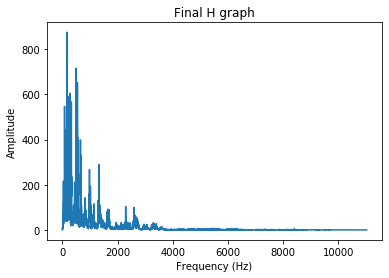

In [4]:
# tries different pitch values for function H
# to reduce the time, select the smaller range for the pitch. 


values = np.empty(sr//2-1)
for i in range(0, sr//2-1):
    values[i] = calculate_H(i)

print("Estimated pitch: " + str(estimate_pitch(values)) + " Hz")

plt.figure()
plt.title("Final H graph")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.plot(values)